In [985]:
import pandas as pd
xls = pd.ExcelFile("/Users/karan7798z/Documents/KPMG_Virtual_Internship/KPMG_VI_New_raw_data_update_final.xlsx")
df_transactions = pd.read_excel(xls, sheet_name='Transactions')
df_demographics = pd.read_excel(xls, sheet_name='CustomerDemographic')
df_addresses = pd.read_excel(xls, sheet_name='CustomerAddress')
df_new_cust = pd.read_excel(xls, sheet_name='NewCustomerList')

In [986]:
df_demographics['gender'].replace(['Female', 'Femal'], 'F', inplace=True)
df_demographics['gender'].replace('Male', 'M', inplace=True)

In [987]:
df_addresses['state'].replace('Victoria', 'VIC', inplace=True)
df_addresses['state'].replace('New South Wales', 'NSW', inplace=True)

In [988]:
now = pd.Timestamp('now')
df_demographics['age'] = (now - df_demographics['DOB']).astype('<m8[Y]')
df_new_cust['age'] = (now - df_new_cust['DOB']).astype('<m8[Y]')
df_demographics['age_range'] = pd.cut(df_demographics['age'], bins=5)

In [989]:
df_merged1 = pd.merge(df_transactions, df_demographics, on='customer_id', how='left')

In [990]:
df_merged = pd.merge(df_merged1, df_addresses, on='customer_id', how='left')

In [991]:
df_merged.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,wealth_segment_y,deceased_indicator_y,owns_car_y,tenure_y,address_y,postcode_y,state_y,country_y,property_valuation_y,locality
0,94,86,1,2017-12-23,0.0,Approved,OHM Cycles,Standard,medium,medium,...,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,NSW,Australia,10.0,REDFERN
1,3765,38,1,2017-04-06,1.0,Approved,Solex,Standard,medium,medium,...,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,NSW,Australia,10.0,REDFERN
2,5157,47,1,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,...,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,NSW,Australia,10.0,REDFERN
3,9785,72,1,2017-01-05,0.0,Approved,Norco Bicycles,Standard,medium,medium,...,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,NSW,Australia,10.0,REDFERN
4,13424,2,1,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,...,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,NSW,Australia,10.0,REDFERN


In [992]:
df_merged['Recency'] = df_merged['transaction_date'].max() - df_merged['transaction_date']

In [993]:
df_grouped = df_merged.groupby('customer_id').agg({'Recency': 'min', 'product_id': 'count', 'profit_loss': 'sum'}).rename(columns={'product_id': 'no_of_products', 'profit_loss': 'total_profit'})
df_grouped.head()

,Recency,no_of_products,total_profit
customer_id,,,
1,7 days,11,3018.09
2,128 days,3,2226.26
3,102 days,8,3362.81
4,195 days,2,220.57
5,16 days,6,2394.94


Now to divide our customers after identifying who our best/most beneficial customers are, we'll use the RFM Matrix. RFM Stands for Recency, Frequency and Monetary Value and is a customer segmentation technique that uses past purchase behaviour to divide customers into groups.

In [994]:
df_grouped['Recency'] = df_grouped['Recency'].dt.days

In [995]:
quantiles = df_grouped.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [996]:
quantiles

{'Recency': {0.25: 17.0, 0.5: 44.0, 0.75: 87.0},
 'no_of_products': {0.25: 4.0, 0.5: 5.0, 0.75: 7.0},
 'total_profit': {0.25: 1829.055, 0.5: 2841.035, 0.75: 4150.51}}

In [997]:
copy_df = df_grouped

In [998]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [999]:
copy_df['r_quartile'] = copy_df['Recency'].apply(RScore, args=('Recency',quantiles,))
copy_df['f_quartile'] = copy_df['no_of_products'].apply(FMScore, args=('no_of_products',quantiles,))
copy_df['m_quartile'] = copy_df['total_profit'].apply(FMScore, args=('total_profit',quantiles,))
copy_df.head()

,Recency,no_of_products,total_profit,r_quartile,f_quartile,m_quartile
customer_id,,,,,,
1,7,11,3018.09,4,4,3
2,128,3,2226.26,1,1,2
3,102,8,3362.81,1,4,3
4,195,2,220.57,1,1,1
5,16,6,2394.94,4,3,2


In [1000]:
copy_df['RFM_Score'] = 100*copy_df['r_quartile'] + 10*copy_df['f_quartile'] + copy_df['m_quartile']
copy_df.head()

,Recency,no_of_products,total_profit,r_quartile,f_quartile,m_quartile,RFM_Score
customer_id,,,,,,,
1,7,11,3018.09,4,4,3,443
2,128,3,2226.26,1,1,2,112
3,102,8,3362.81,1,4,3,143
4,195,2,220.57,1,1,1,111
5,16,6,2394.94,4,3,2,432


In [1001]:
quantiles = copy_df.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 17.0, 0.5: 44.0, 0.75: 87.0},
 'no_of_products': {0.25: 4.0, 0.5: 5.0, 0.75: 7.0},
 'total_profit': {0.25: 1829.055, 0.5: 2841.035, 0.75: 4150.51},
 'r_quartile': {0.25: 2.0, 0.5: 3.0, 0.75: 4.0},
 'f_quartile': {0.25: 1.0, 0.5: 2.0, 0.75: 3.0},
 'm_quartile': {0.25: 1.75, 0.5: 2.5, 0.75: 3.25},
 'RFM_Score': {0.25: 211.0, 0.5: 311.0, 0.75: 411.0}}

In [1002]:
quantiles2 = copy_df.quantile(q=[0.125,0.25,0.375,0.5,0.625,0.75,0.875])
quantiles2 = quantiles2.to_dict()
quantiles2

{'Recency': {0.125: 9.0,
  0.25: 17.0,
  0.375: 30.0,
  0.5: 44.0,
  0.625: 62.0,
  0.75: 87.0,
  0.875: 132.0},
 'no_of_products': {0.125: 3.0,
  0.25: 4.0,
  0.375: 5.0,
  0.5: 5.0,
  0.625: 6.0,
  0.75: 7.0,
  0.875: 8.0},
 'total_profit': {0.125: 1168.84,
  0.25: 1829.055,
  0.375: 2339.30125,
  0.5: 2841.035,
  0.625: 3456.560000000001,
  0.75: 4150.51,
  0.875: 5146.172500000001},
 'r_quartile': {0.125: 1.0,
  0.25: 2.0,
  0.375: 2.0,
  0.5: 3.0,
  0.625: 3.0,
  0.75: 4.0,
  0.875: 4.0},
 'f_quartile': {0.125: 1.0,
  0.25: 1.0,
  0.375: 2.0,
  0.5: 2.0,
  0.625: 3.0,
  0.75: 3.0,
  0.875: 4.0},
 'm_quartile': {0.125: 1.0,
  0.25: 1.75,
  0.375: 2.0,
  0.5: 2.5,
  0.625: 3.0,
  0.75: 3.25,
  0.875: 4.0},
 'RFM_Score': {0.125: 113.0,
  0.25: 211.0,
  0.375: 232.0,
  0.5: 311.0,
  0.625: 332.0,
  0.75: 411.0,
  0.875: 432.0}}

In [1003]:
def category_assignment(x,p,d):
    if x <= d[p][0.125]:
        return "Almost Lost"
    elif x < d[p][0.25]:
        return "Need Attention"
    elif (x >= d[p][0.25] and x < d[p][0.375]):
        return 'Hibernating'
    elif (x >= d[p][0.375] and x < d[p][0.50]):
        return 'Promising Customers'
    elif (x >= d[p][0.50] and x < d[p][0.625]):
        return 'Potential Loyalists'    
    elif (x >= d[p][0.625] and x < d[p][0.75]): 
        return 'Loyal Customers'
    elif (x >= d[p][0.75] and x < d[p][0.875]): 
        return 'New Customers'    
    else:
        return 'Platinum Customers'

In [1004]:
copy_df['customer_category'] = copy_df['RFM_Score'].apply(category_assignment, args=('RFM_Score', quantiles2))
copy_df

,Recency,no_of_products,total_profit,r_quartile,f_quartile,m_quartile,RFM_Score,customer_category
customer_id,,,,,,,,
1,7,11,3018.09,4,4,3,443,Platinum Customers
2,128,3,2226.26,1,1,2,112,Almost Lost
3,102,8,3362.81,1,4,3,143,Need Attention
4,195,2,220.57,1,1,1,111,Almost Lost
5,16,6,2394.94,4,3,2,432,Platinum Customers
6,64,5,3946.55,2,2,3,223,Hibernating
7,253,3,220.11,1,1,1,111,Almost Lost
8,22,10,7066.94,3,4,4,344,Loyal Customers
9,78,6,2353.11,2,3,2,232,Promising Customers


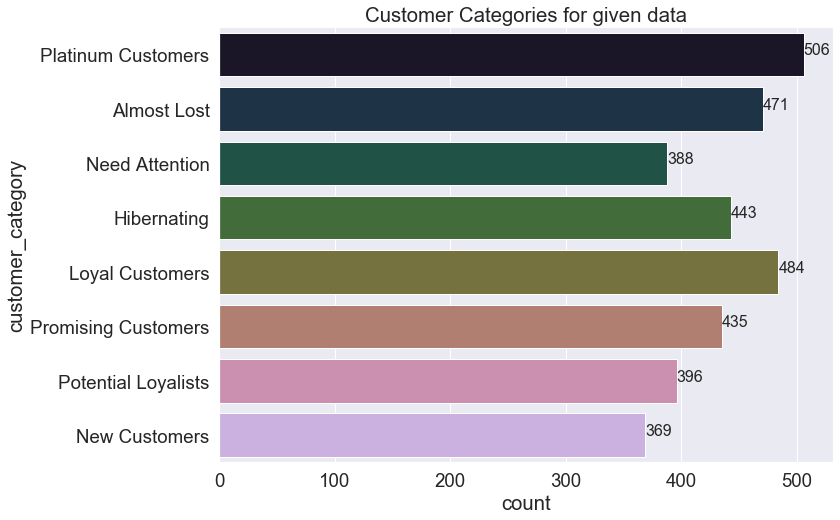

In [1005]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(11,8))
sns.set(font_scale=1.7)
plt.title('Customer Categories for given data')
g = sns.countplot(y=copy_df['customer_category'], palette=sns.color_palette("cubehelix", 10))
for p in g.patches:
        value = '{:.0f}'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        g.annotate(value, (x, y), size=16)
plt.show()

Text(0, 0.5, 'Monetary Value')

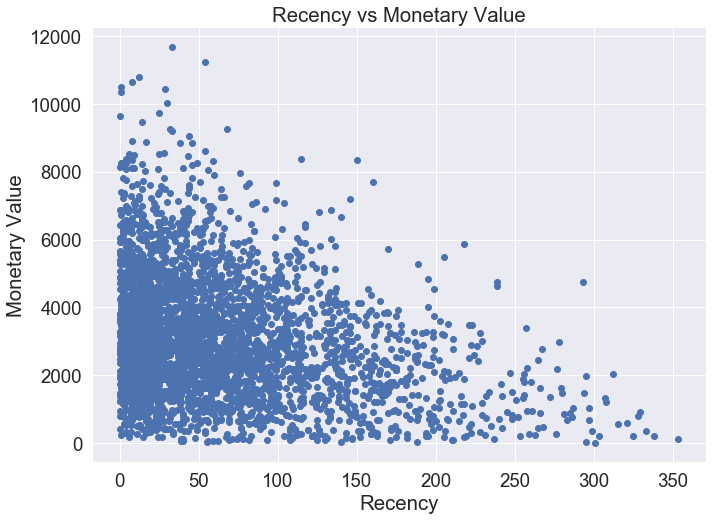

In [1006]:
plt.figure(figsize=(11,8))
plt.title('Recency vs Monetary Value')
plt.scatter(copy_df['Recency'], copy_df['total_profit'])
plt.xlabel('Recency')
plt.ylabel('Monetary Value')

Text(0, 0.5, 'Frequency')

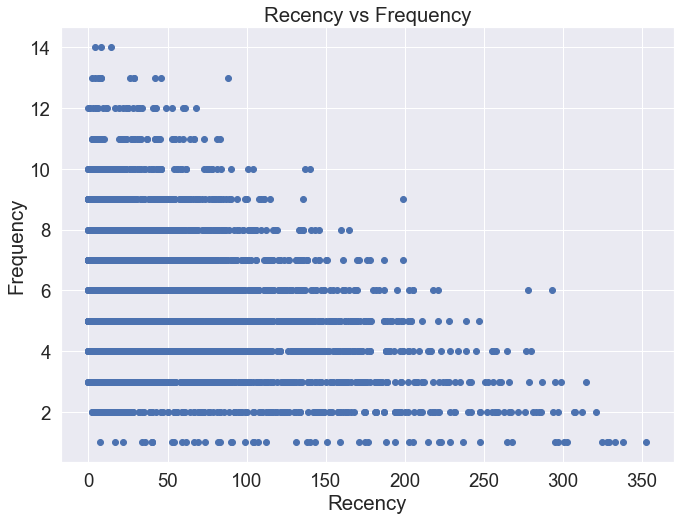

In [1007]:
plt.figure(figsize=(11,8))
plt.title('Recency vs Frequency')
plt.scatter(copy_df['Recency'], copy_df['no_of_products'])
plt.xlabel('Recency')
plt.ylabel('Frequency')

Text(0, 0.5, 'Monetary Value')

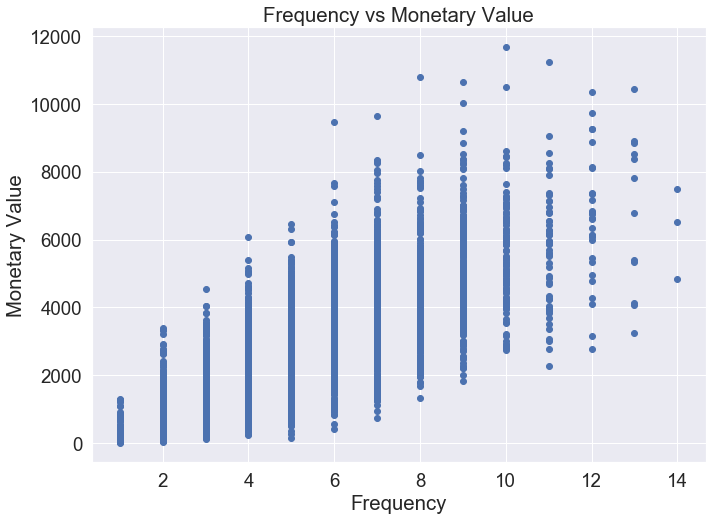

In [1008]:
plt.figure(figsize=(11,8))
plt.title('Frequency vs Monetary Value')
plt.scatter(copy_df['no_of_products'], copy_df['total_profit'])
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')

In [1009]:
categories = copy_df['customer_category'].reset_index()

In [1010]:
categories.head()

,customer_id,customer_category
0,1,Platinum Customers
1,2,Almost Lost
2,3,Need Attention
3,4,Almost Lost
4,5,Platinum Customers


In [1011]:
df_merged2 = pd.merge(df_demographics, df_addresses, on='customer_id', how='left')
df_merged2.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,age,age_range,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,locality
0,1,Laraine,Medendorp,F,93,1953-10-12,66.0,"(60.0, 74.0]",Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016.0,NSW,Australia,10.0,REDFERN
1,2,Eli,Bockman,M,81,1980-12-16,39.0,"(32.0, 46.0]",Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,6 Meadow Vale Court,2153.0,NSW,Australia,10.0,BAULKHAM HILLS
2,3,Arlin,Dearle,M,61,1954-01-20,66.0,"(60.0, 74.0]",Recruiting Manager,Property,Mass Customer,N,Yes,15.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Talbot,NaN,M,33,1961-10-03,58.0,"(46.0, 60.0]",NaN,IT,Mass Customer,N,No,7.0,0 Holy Cross Court,4211.0,QLD,Australia,9.0,ADVANCETOWN
4,5,Sheila-kathryn,Calton,F,56,1977-05-13,43.0,"(32.0, 46.0]",Senior Editor,NaN,Affluent Customer,N,Yes,8.0,17979 Del Mar Point,2448.0,NSW,Australia,4.0,HYLAND PARK


In [1012]:
df_merged_with_category = pd.merge(df_merged2, categories, on='customer_id')

In [1013]:
df_merged_with_category.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,age,age_range,job_title,job_industry_category,...,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,locality,customer_category
0,1,Laraine,Medendorp,F,93,1953-10-12,66.0,"(60.0, 74.0]",Executive Secretary,Health,...,N,Yes,11.0,060 Morning Avenue,2016.0,NSW,Australia,10.0,REDFERN,Platinum Customers
1,2,Eli,Bockman,M,81,1980-12-16,39.0,"(32.0, 46.0]",Administrative Officer,Financial Services,...,N,Yes,16.0,6 Meadow Vale Court,2153.0,NSW,Australia,10.0,BAULKHAM HILLS,Almost Lost
2,3,Arlin,Dearle,M,61,1954-01-20,66.0,"(60.0, 74.0]",Recruiting Manager,Property,...,N,Yes,15.0,NaN,NaN,NaN,NaN,NaN,NaN,Need Attention
3,4,Talbot,NaN,M,33,1961-10-03,58.0,"(46.0, 60.0]",NaN,IT,...,N,No,7.0,0 Holy Cross Court,4211.0,QLD,Australia,9.0,ADVANCETOWN,Almost Lost
4,5,Sheila-kathryn,Calton,F,56,1977-05-13,43.0,"(32.0, 46.0]",Senior Editor,NaN,...,N,Yes,8.0,17979 Del Mar Point,2448.0,NSW,Australia,4.0,HYLAND PARK,Platinum Customers
